Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [37]:
from random import choices
from random import random, choice, randint
from functools import reduce
from collections import namedtuple
from dataclasses import dataclass
from copy import copy
import matplotlib.pyplot as plt
from pprint import pprint

import numpy as np

import lab9_lib

In [38]:
POPULATION_SIZE = 100
TOURNAMENT_SIZE = 2
MUTATION_PROBABILITY = 0.01
MIGRATION_PROBABILITY=0.01
LOCI=1000
num_islands=POPULATION_SIZE//10
ISLAND_SIZE=POPULATION_SIZE//num_islands
OFFSPRING_SIZE =ISLAND_SIZE//4

In [39]:
fitness = lab9_lib.make_problem(1)


"""
fit=0
while fit<0.9:
    ind = choices([0, 1], k=50)
    fit=fitness(ind)
 
    print(f"{''.join(str(g) for g in ind)}: {fit:.2%}")

print(fitness.calls) """

'\nfit=0\nwhile fit<0.9:\n    ind = choices([0, 1], k=50)\n    fit=fitness(ind)\n \n    print(f"{\'\'.join(str(g) for g in ind)}: {fit:.2%}")\n\nprint(fitness.calls) '

In [40]:
@dataclass
class Individual:
   
    fitness: float
    genotype: list[int]

      
    def __eq__(self, other):
        if isinstance(other, Individual):
            return self.fitness == other.fitness and self.genotype == other.genotype
        return False

    def __hash__(self):
        # Using hash() on a tuple of hashable attributes
        return hash(self.fitness)

def select_parent(pop):
    
    pool = [choice(pop) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion
    

def mutate_1(ind: Individual) -> Individual:
    """ bit-flip mutation """
    l=len(ind.genotype)
    #p=1/l
    p=MUTATION_PROBABILITY
    #print("original individual", ind.genotype)
    
    for i in range(l):
        if p>= np.random.normal():
            ind.genotype[i]=1-ind.genotype[i]
    
    #print("mutated individual", ind.genotype)
    return ind


def mutate(ind: Individual) -> Individual:
    offspring = copy(ind)
    pos = randint(0, LOCI-1)
    offspring.genotype[pos] = 1- offspring.genotype[pos]
    offspring.fitness = None
    return offspring

def one_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    cut_point = randint(0, LOCI-1)
    offspring_1 = Individual(fitness=None,
                           genotype=ind1.genotype[:cut_point] + ind2.genotype[cut_point:])
    offspring_2 = Individual(fitness=None,
                           genotype=ind2.genotype[:cut_point] + ind1.genotype[cut_point:])
    assert len(offspring_1.genotype) == LOCI
    return offspring_1, offspring_2

def two_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    cut_point_1= randint(0, LOCI-1)
    cut_point_2= randint(0, LOCI-1)

    if cut_point_1>cut_point_2:
        cut_point_1,cut_point_2=cut_point_2,cut_point_1

    if cut_point_1 != cut_point_2:
        ind1.genotype[cut_point_1::cut_point_2],ind2.genotype[cut_point_1::cut_point_2]=ind2.genotype[cut_point_1::cut_point_2],ind1.genotype[cut_point_1::cut_point_2]
    """ 
        for i in range(cut_point_1,cut_point_2):
            ind1.genotype[cut_point_1::cut_point_2],ind2.genotype[cut_point_1::cut_point_2]=ind2.genotype[cut_point_1::cut_point_2][::-1],ind1.genotype[cut_point_1::cut_point_2][::-1]
    """
    return ind1,ind2

def uniform_cut_xover(ind1: Individual, ind2: Individual) -> Individual:

    l=len(ind1.genotype)
    p=1/l
    """ print("parent1", ind1.genotype)
    print("parent2", ind2.genotype)
    for i in range(l):
        for j in range(-l,0):
            if p >=np.random.normal():
                #j=-l+i
                ind1.genotype[i],ind2.genotype[i]=ind2.genotype[j],ind1.genotype[j]
            
          
    print("child1", ind1.genotype)
    print("child2", ind2.genotype) """
    for i in range(l):
    
        if p >=np.random.normal():
            j=-l+i
            ind1.genotype[i],ind2.genotype[i]=ind2.genotype[i],ind1.genotype[i]
        
        
    #print("child1", ind1.genotype)
    return ind1,ind2

In [41]:
def generation(population,crossover):
    
    offspring = list()

    for i in range(OFFSPRING_SIZE):
        if random() < MUTATION_PROBABILITY:  # self-adapt mutation probability
            p = select_parent(population)
            o = mutate_1(p)
            offspring.append(o)
        else:
            # xover # add more xovers
            p1 = select_parent(population)
            p2 = select_parent(population)
            if crossover==one_cut_xover:
                o1,o2= one_cut_xover(p1, p2)
    
            elif crossover==two_cut_xover:
                o1,o2=two_cut_xover(p1,p2)
            
            offspring.append(o1)
            offspring.append(o2)
            i+=2
            
    for i in offspring:
        i.fitness = fitness(i.genotype)

    #----------------remove previous duplicates------------
    population = list(set(population))
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness, reverse=True)
    population=population[:ISLAND_SIZE]
    best_fitness=population[0].fitness

    return best_fitness,population



## GA

In [ ]:

population = [
    Individual(
        genotype=[choice((0, 1)) for _ in range(LOCI)],
        fitness=None,
    )
    for _ in range(POPULATION_SIZE)
]


for i in population:
    i.fitness = fitness(i.genotype)

best_fitnesses=[]
num_iterations=30000
for _ in range(num_iterations):
    new_fitness, population= generation(population, one_cut_xover)
    best_fitnesses.append(new_fitness)
    #print(new_fitness)
plt.plot( range(0,num_iterations), best_fitnesses)
plt.title("Genetic Algorithm without duplicates")
plt.xlabel("iterations")
plt.ylabel("fitness")

## ISLANDS MODEL

iteration 0 best  0.54
MUTATION 0.01
iteration 50 best  0.587
MUTATION 0.0105
iteration 100 best  0.587
MUTATION 0.012155062500000004
iteration 150 best  0.595
MUTATION 0.013400956406250006
iteration 200 best  0.596
MUTATION 0.014774554437890632
iteration 250 best  0.598
MUTATION 0.017103393581163143
iteration 300 best  0.611
MUTATION 0.0179585632602213
iteration 350 best  0.615
MUTATION 0.010394640897056842
iteration 400 best  0.621
MUTATION 0.01146009158900517
iteration 450 best  0.622
MUTATION 0.0126347509768782
iteration 500 best  0.624
MUTATION 0.013929812952008215
iteration 550 best  0.624
MUTATION 0.01612549971856851
iteration 600 best  0.628
MUTATION 0.017778363439721785
iteration 650 best  0.631
MUTATION 0.01960064569229327
iteration 700 best  0.631
MUTATION 0.022690197469541
iteration 750 best  0.634
MUTATION 0.02501594271016895
iteration 800 best  0.641
MUTATION 0.027580076837961272
iteration 850 best  0.642
MUTATION 0.030407034713852307
iteration 900 best  0.643
MUTATION 0.

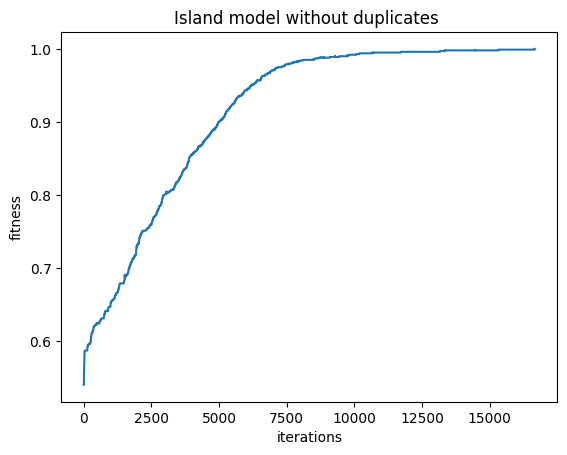

In [43]:
@dataclass
class Island:
    population: list[Individual]
    crossover: callable

    
def migration(islands):
    #print(len(islands[0].population))
    migrants=[]
    num_migrants=2
    for i in range(len(islands)):
        for _ in range(num_migrants):
            if random()<0.5:
                migrant=max(islands[i].population, key=lambda x: x.fitness)
            else:
                migrant=choice(islands[i].population)
      
            islands[i].population.remove(migrant)
     
            migrants.append(migrant)

    for i in range (len(islands)):
        for j in range(len(migrants)):
            if i==0:
                islands[i].population.append(migrants[len(migrants)-j-1])
            else:
                islands[i].population.append(migrants[i*num_migrants-j-1])
                
    return islands


population = [
    Individual(
        genotype=[choice((0, 1)) for _ in range(LOCI)],
        fitness=None,
    )
    for _ in range(POPULATION_SIZE)
]



for i in population:
    i.fitness = fitness(i.genotype)


islands=[]
# Create the islands with similar individual
population.sort(key=lambda i: i.fitness, reverse=True)
   
j=0
for i in range(0, len(population), ISLAND_SIZE):
    j+=1
    sublist = population[i:i + ISLAND_SIZE]
    if random()<0.5:
        islands.append(Island(population=sublist, crossover=one_cut_xover))
    else:
        islands.append(Island(population=sublist, crossover=two_cut_xover))

#print(*islands, sep="\n")


best_fitnesses=[0 for _ in range(num_islands)]
max_fitness=0
max_fitnesses=[]
it=0
same=0
last_fitness=0
increasing=0
decreasing=0

#while max_fitness!=1.0:
for i in range(30000):   
    
    last_fitness=max_fitness

    for j in range(len(islands)):
        best_fitnesses[j],islands[j].population=generation(islands[j].population,islands[j].crossover)
    
    #print(len(islands[0].population))
       
    max_fitness=max(best_fitnesses)
    max_fitnesses.append(max_fitness)
    
    if i%50==0:
        print("iteration", i, "best ",  max_fitness)
        print("MUTATION",MUTATION_PROBABILITY)
        #print("MIGRATION", MIGRATION_PROBABILITY)

    if random()<MIGRATION_PROBABILITY:
       islands=migration(islands)

    """  if max_fitness>0.9 and MUTATION_PROBABILITY>0.3:
       
            MUTATION_PROBABILITY*=0.5
            MIGRATION_PROBABILITY*=0.5
            TOURNAMENT_SIZE*=2 """
    
    if max_fitness > last_fitness:
    
        increasing+=1
        if increasing>30:
            increasing=0
            MUTATION_PROBABILITY*=0.5
            MIGRATION_PROBABILITY*=0.5

    else:
        decreasing+=1
        if decreasing>20 and MUTATION_PROBABILITY<0.25:
            decreasing=0
            MUTATION_PROBABILITY*=1.05
            MIGRATION_PROBABILITY*=1.05        
    it=i+1
    if max_fitness==1.0:
        break;
   
plt.title("Island model without duplicates ")
plt.xlabel("iterations")
plt.ylabel("fitness")
plt.plot( range(0,it), max_fitnesses)
print("-------------------FITNESS CALLS-------------", fitness.calls)